In [99]:
from datetime import datetime

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
cdc_data = pd.read_csv("../data/data_table_for_daily_death_trends__the_united_states.csv")

In [4]:
cdc_data

,State,Date,New Deaths,7-Day Moving Avg,Historic Deaths
0,United States,Apr 26 2022,347,299,20
1,United States,Apr 25 2022,179,309,37
2,United States,Apr 24 2022,36,335,0
3,United States,Apr 23 2022,54,336,0
4,United States,Apr 22 2022,514,332,-227
...,...,...,...,...,...
820,United States,Jan 27 2020,0,0,0
821,United States,Jan 26 2020,0,0,0
822,United States,Jan 25 2020,0,0,0
823,United States,Jan 24 2020,0,0,0


In [66]:

cdc_data["Formatted Date"] = cdc_data.Date.map(lambda d: datetime.strptime(d, '%b %d %Y').strftime('%Y %b %d'))
cdc_data["Month"] = cdc_data.Date.map(lambda d: datetime.strptime(d, '%b %d %Y').strftime('%m'))
cdc_data["Year"] = cdc_data.Date.map(lambda d: datetime.strptime(d, '%b %d %Y').strftime('%Y'))
cdc_data["Year + Month"] = cdc_data[["Year", "Month"]].apply(lambda row: "-".join((row.Year, row.Month)), axis=1)

cdc_data["Month"].unique(), cdc_data["Year"].unique(), cdc_data["Year + Month"].unique()

(array(['04', '03', '02', '01', '12', '11', '10', '09', '08', '07', '06',
        '05'], dtype=object),
 array(['2022', '2021', '2020'], dtype=object),
 array(['2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11',
        '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05',
        '2021-04', '2021-03', '2021-02', '2021-01', '2020-12', '2020-11',
        '2020-10', '2020-09', '2020-08', '2020-07', '2020-06', '2020-05',
        '2020-04', '2020-03', '2020-02', '2020-01'], dtype=object))

In [67]:
cdc_data["New Deaths"] = cdc_data["New Deaths"].astype(int)

/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


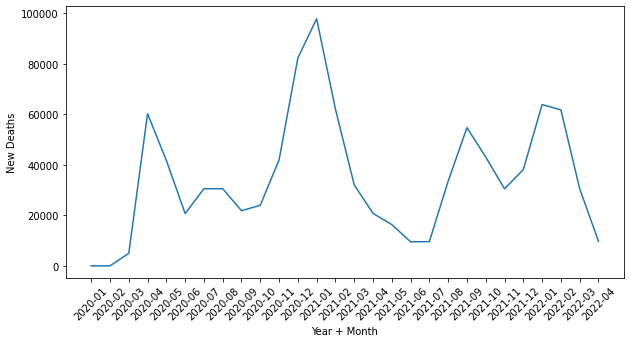

In [184]:
cdc_data_grouped = cdc_data.groupby(["Year + Month"]).agg("sum").sort_values(by=["Year + Month"])
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=cdc_data_grouped, x="Year + Month", y="New Deaths", ax=ax)
# plt.show()
ax.set_xticklabels(cdc_data_grouped.index, rotation=45);

In [186]:
cdc_data_fit = cdc_data_grouped.reset_index()

In [189]:
cdc_data_fit["Year + Month"].values

array(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04'], dtype=object)

In [191]:
x, y = np.arange(len(cdc_data_fit)), cdc_data_fit["New Deaths"].astype(int).values
lr = LinearRegression().fit(x.reshape(-1, 1), y)

In [192]:
lr.predict(x.reshape(-1, 1))

array([26649.70197044, 27248.90394089, 27848.10591133, 28447.30788177,
       29046.50985222, 29645.71182266, 30244.9137931 , 30844.11576355,
       31443.31773399, 32042.51970443, 32641.72167488, 33240.92364532,
       33840.12561576, 34439.32758621, 35038.52955665, 35637.73152709,
       36236.93349754, 36836.13546798, 37435.33743842, 38034.53940887,
       38633.74137931, 39232.94334975, 39832.1453202 , 40431.34729064,
       41030.54926108, 41629.75123153, 42228.95320197, 42828.15517241])

In [193]:
lr.predict(np.array([[3]]))

array([28447.30788177])

In [232]:
def construct_features(y, n_past_months=3, include_next_month=False):
    features = []
    for n_look_back in range(1, n_past_months+1):
        y_shifted = y[:(-n_look_back + include_next_month)] if (-n_look_back + include_next_month) < 0 else y
        features.append(np.concatenate((np.zeros(n_look_back), y_shifted)))
    return np.stack(features, axis=1)

X = construct_features(y, n_past_months=4)
pr = make_pipeline(PolynomialFeatures(1), LinearRegression()).fit(X, y)

/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


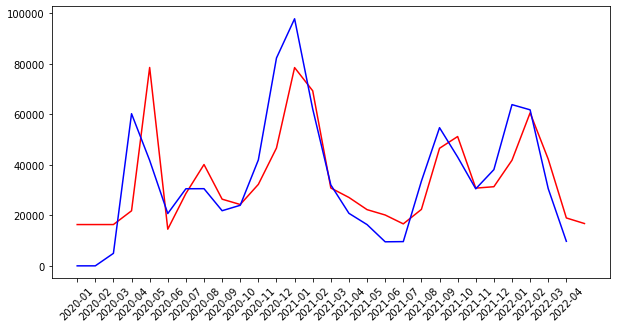

In [234]:
fig, ax = plt.subplots(figsize=(10, 5))
# X_pred = np.stack((np.concatenate(([0, 0], y[:-1])), np.concatenate(([0], y))), axis=1)
X_pred = construct_features(y, n_past_months=4, include_next_month=True)
sns.lineplot(np.concatenate([x, [x.max()+1]]), pr.predict(X_pred), ax=ax, color="red")
sns.lineplot(x, y, ax=ax, color="blue")
ax.set_xticks(x)
ax.set_xticklabels(cdc_data_fit["Year + Month"].values, rotation=45);

In [202]:
pr.predict(X_pred)[-1]

12448.043176533216

In [165]:
y

0         0
1         2
2      4952
3     60233
4     41748
5     20709
6     30518
7     30547
8     21827
9     23976
10    41944
11    82274
12    97817
13    62093
14    32039
15    20791
16    16336
17     9520
18     9595
19    33529
20    54695
21    43076
22    30497
23    38095
24    63824
25    61767
26    30565
27     9721
Name: New Deaths, dtype: int64

/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/stephenmalina/.local/share/virtualenvs/dyno_ml-rbe_KkuJ/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


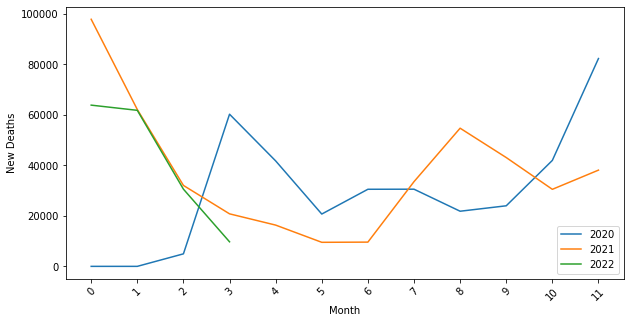

In [119]:
cdc_data_grouped = cdc_data.groupby(["Year", "Month"]).agg("sum").sort_values(by=["Year", "Month"]).reset_index()
fig, ax = plt.subplots(figsize=(10, 5))
for year in cdc_data_grouped.Year.unique():
    cdc_data_grouped_year = cdc_data_grouped.query("Year == @year")
    sns.lineplot(data=cdc_data_grouped_year, x="Month", y="New Deaths", ax=ax, label=year)
    ax.set_xticklabels(cdc_data_grouped.index, rotation=45);
ax.legend();

In [179]:
cdc_data_grouped.query("Year == '2022'")

,Year,Month,New Deaths,7-Day Moving Avg,Historic Deaths
24,2022,01,63824,61701,1842
25,2022,02,61767,63789,362
26,2022,03,30565,32873,-4017
27,2022,04,9721,11211,313
